# Part 7: Advanced Panoramic Image

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
import random as rm
import math
import cv2
from tkinter import *
from tkinter import messagebox
from PIL import Image, ImageTk
import random

### 1.Handling unordered images

In [2]:
# mini square
def knear(des,k):
    # des: list of class descripter
    # k: the k nearest 
    row = len(des)
    col = len(des[0].des)
    
    dcp = np.zeros([row,col])
    # extract descripter vector in class des
    for i in range(0,row):
        dcp[i,:] = des[i].des
        
    
    # find mini distance position
    # return the k nearest points' index in des
    for j in range(0,row):
        # compute distance
        dis = np.zeros([row,1])
        diff = dcp - dcp[j]
#         print(diff)
        dis = np.sqrt(np.sum(diff * diff,axis = 1))
        dis = np.matrix(dis)
#         print(dis)

        # sort increase
        order = np.lexsort(dis)
#         print(order[0,1:k+1])
        des[j].near = order[0,1:k+1]
    
    return des
                

In [3]:
# Find SIFT and return Homography Matrix
def SIFT(im,order):

    # Initialize SIFT 
    sift=cv2.SIFT_create() 
    
    # turn to grayscale
    im = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)

    # Extract keypoints and descriptors
    kp,d=sift.detectAndCompute(im,None)
    
    # insert kp and des
    row = len(d)
    point = []
    for i in range(0,row):
        point.append(keypoint())
        point[i].pos = kp[i].pt
        point[i].im = order
        point[i].des = d[i]
        
    return point

In [4]:
# homography computing
def hmat(points):
    row = len(points)
    n_mat = int(row/2)
    A = np.zeros([row,9])
    
    for i in range(0,n_mat):
        h1_x = points[i][0]
        h1_y = points[i][1]
        h2_x = points[i+n_mat][0]
        h2_y = points[i+n_mat][1]
        A[2*i][:] = [h1_x,h1_y,1,0,0,0,-h2_x*h1_x,-h2_x*h1_y,-h2_x]
        A[2*i+1][:] = [0,0,0,h1_x,h1_y,1,-h2_y*h1_x,-h2_y*h1_y,-h2_y]

    _, _, vt = linalg.svd(A)
    H = vt[-1].reshape(3,3)
    H = H / H[2,2] # H(3,3) = 1

    return H

In [5]:
# count inliers
def inlier(H,mp,matches,threshold):
    row = len(mp)
    p1 = mp[:,0:2]
    p2 = mp[:,2:4]
    
    x1 = np.concatenate((p1,np.ones([row,1])),axis = 1)
    # transfer 
    x2 = np.dot(H,x1.T)
    x2 = x2[0:2,:]/x2[2,:]
    es_p2 = x2[0:2,:].T
    
    # distance
    diff = p2 - es_p2
    sq = diff * diff
    dis = np.sqrt(sq[:,0] + sq[:,1])
    
    # calculate the number of points that distance < threshold
    # inliers' position
    match = []
    for i in range(0,row):
        if dis[i] < threshold:
            match.append(matches[i])
    
    return match

In [6]:
# RANSAC + Homography
def homo_ransac(kp1,kp2,matches,repeat):
    # n the pairs of keypoints selected randomly (n >= 4)
    n = 4
    # loop times
    loop = repeat
    # HH the largest inliers H
    HH = []
    # threshold of the inliers distance
    threshold = 1
    # inliers box
    num_in = 0
    
    # change the kp1 and kp2 from tuple to list
    N = len(matches)
    k1 = np.zeros([N,2])
    k2 = np.zeros([N,2])

    # Get the coordinate of keypoint
    for i in range(N):
        for j in range(2):
            k1[i,j] = kp1[matches[i].queryIdx].pt[j]
            k2[i,j] = kp2[matches[i].trainIdx].pt[j]
    
    # matched points
    mp = np.concatenate((k1,k2),axis = 1)
    
    for i in range(0,loop):
        # Use four random pair of keypoints to compute the homography matrix
        rdm = random.sample(range(0,N),4)
        points = np.array([[k1[rdm[0]][0],k1[rdm[0]][1]],[k1[rdm[1]][0],k1[rdm[1]][1]],
                      [k1[rdm[2]][0],k1[rdm[2]][1]],[k1[rdm[3]][0],k1[rdm[3]][1]],
                            [k2[rdm[0]][0],k2[rdm[0]][1]],[k2[rdm[1]][0],k2[rdm[1]][1]],
                      [k2[rdm[2]][0],k2[rdm[2]][1]],[k2[rdm[3]][0],k2[rdm[3]][1]]])
        
        # compute H
        H = hmat(points)
        
        # count inliers
        match = inlier(H,mp,matches,threshold)
        
        # keep the max inliers parameter
        if len(match) > num_in:
            num_in = len(match)
            HH = H
            match_best = match

    return HH,match_best
        

In [7]:
# build a canvas
def get_canvas(im1,im2,Hi):
    # Hi is im2 to im1
    [row1,col1,c] = im1.shape
    [row2,col2,c] = im2.shape

    # get the edge
    [x_max,x_min,y_max,y_min] = get_size(im2,Hi)
    print([x_min,x_max,y_min,y_max])
    x_minus = int(np.min([0,x_min])-10)
    x_plus = int(np.max([0,x_max-row1])+10)
    y_minus = int(np.min([0,y_min])-10)
    y_plus = int(np.max([0,y_max-col1])+10)
    
    # x direction adding space
    add_x_minus = np.zeros([-x_minus,col1,c])
    add_x_plus = np.zeros([x_plus,col1,c])
    
    # y direction adding space
    add_y_minus = np.zeros([-x_minus+row1+x_plus,-y_minus,c])
    add_y_plus = np.zeros([-x_minus+row1+x_plus,y_plus,c])
    
    # concatenate the adding space with im1
    canvas = np.concatenate((add_x_minus,im1,add_x_plus),axis = 0)
    canvas = np.concatenate((add_y_minus,canvas,add_y_plus),axis = 1)
    
    return canvas.astype(int),[x_minus,y_minus]





In [8]:
# transform h1 to h2
def get_size(h1,H):
    [row,col,c] = h1.shape
    
    # 4 cornor of the image h1
    lt = np.array([[0,0,1]])
    rt = np.array([[0,col,1]])
    lb = np.array([[row,0,1]])
    rb = np.array([[row,col,1]])
    
    # edge matrix
    edge = np.concatenate((lt,rt,lb,rb),axis = 0).T
    
    T_edge = np.dot(H,edge)
    # normalize
    T_edge = T_edge[0:2,:]/T_edge[2,:]
    T_edge = T_edge
    
    return np.max(T_edge[0,:]),np.min(T_edge[0,:]),np.max(T_edge[1,:]),np.min(T_edge[1,:])
    

In [9]:
def trans2im1(canvas,im2,Hi,compensation,step):
    # the wight of the im1 when overlay
    w = 0.6
    
    # step of the transmitting 1/step
    [row,col,c] = im2.shape
    
    # draw im2 on the canvas
    for j in range(0,row*step):
        for k in range(0,col*step):
            # positon: points of im2 in im1 plane 
            p = np.array([[j/step,k/step,1]]).T
            Tp = np.dot(Hi,p)

            # normalize and move the image
            x2 = int(round(Tp[0,0]/Tp[2,0])-compensation[0])
            y2 = int(round(Tp[1,0]/Tp[2,0])-compensation[1])
            
            # position in im1
            x1 = int(j/step)
            y1 = int(k/step)

            if np.any(canvas[x2,y2] > 0):
                canvas[x2,y2] = w * canvas[x2,y2][:] + (1 - w) * im2[x1,y1][:]
            else:
                canvas[x2,y2] = im2[x1,y1][:]
    
    return canvas.astype(int)
    

In [10]:
# compute Homography from the inliers
def HHmat(kp1,kp2,match_best):
    # change the inliers from tuple to list
    N = len(match_best)
    in1 = np.zeros([N,2])
    in2 = np.zeros([N,2])

    # Get the coordinate of keypoint
    for i in range(N):
        for j in range(2):
            in1[i] = [kp1[match_best[i].queryIdx].pt[1],kp1[match_best[i].queryIdx].pt[0]]
            in2[i] = [kp2[match_best[i].trainIdx].pt[1],kp2[match_best[i].trainIdx].pt[0]]

    # compare the Homography compute from the random points and the inliers
    in_points = np.concatenate((in1,in2),axis = 0)
    H_best = hmat(in_points)
    print(H_best)
#     print(HH)
    
    return H_best,in1,in2

In [11]:
class keypoint:
    def __int__(self):
        self.im = -1
        self.pos = []
        self.des = []
        self.near = []

In [12]:
# switch case
def one():
    return [1,0,0,0,0]

def two():
    return [0,1,0,0,0]

def three():
    return [0,0,1,0,0]

def four():
    return [0,0,0,1,0]

def five():
    return [0,0,0,0,1]
    
def default():
    print("error")
    return [0,0,0,0,0]


def switch(num):
    numbers = {
        1 : one,
        2 : two,
        3 : three,
        4 : four,
        5 : five
    }
        
    return numbers.get(num, default)()



In [13]:
# find the best matched image
# via counting which image has most matched points with others
def mmimage(m_p):
    k = len(m_p)
    
    vote = np.zeros([k,2])
    for i in range(k):
        vote[i] = [i+1,np.argmax(m_p[i])+1]
    
    return vote
        

In [14]:
# choose 2 images should be stitched
def num_stitch(m_p , time = 2):
    
    # first time should choose 2 images
    if time == 1:
        
        vote = mmimage(m_p)
        l = len(vote)
        
        counter = np.zeros(l)
        for [j,k] in vote:
            counter[int(j-1)] += 1
            counter[int(k-1)] += 1

        # most popular image
        [m_order] = np.lexsort(np.matrix(counter))
        m_p1 = m_order[-1]
#         print(m_order,m_p1)

        # find the image matches m_p and is second popular in all images
        im_p2 = -1
        for [j,k] in vote:
            if j == m_p1+1:
#                 print(j,k)
                [index] = np.where(m_order == k-1)
#                 print(index)
                im_p2 = np.max([index,im_p2])
#                 print(im_p2)
            elif k == m_p1+1:
#                 print(j,k)
                [index] = np.where(m_order == j-1)
                im_p2 = np.max([index,im_p2])
#                 print(im_p2)
                
        m_p2 = m_order[im_p2]
        
    else:
        # 0 col is the matched points number
        [m_order] = np.lexsort(np.matrix(m_p[:,0]))
#         print(m_order)
        m_p1 = 0
        m_p2 = m_order[-1]
    
    matches = [m_p1,m_p2]
    
    return matches
    
    

In [15]:
# Find SIFT and return Homography Matrix
def SIFT_old(im1, im2):
    # im1 and im2 are grayscale image

    # Initialize SIFT 
    sift=cv2.SIFT_create() 
    
    # turn to grayscale
    im1 = cv2.cvtColor(im1,cv2.COLOR_BGR2GRAY)
    im2 = cv2.cvtColor(im2,cv2.COLOR_BGR2GRAY)

    # Extract keypoints and descriptors
    kp1,des1=sift.detectAndCompute(im1,None)
    kp2,des2=sift.detectAndCompute(im2,None)

    # match the points
    # using DMatch instead of matrix. matrix not so powerful and easily went wrong
    matches = mini_square_old(des1,des2)
    
#     # Bruteforce matcher on the descriptors
#         another way to match the pairs of points using KNN

#     bruteforce=cv2.BFMatcher()
#     matches=bruteforce.knnMatch(des1,des2, k=2)

#     # Make sure that the matches are good
#     verify_ratio=0.8 
#     verified_matches=[]
#     for m1,m2 in matches:
#         # Add to array only if it's a good match
#         if m1.distance<0.8*m2.distance:
#             #turn DMatch to matrix
#             verified_matches.append([m1.queryIdx,m1.trainIdx])

#     verified_matches = np.matrix(verified_matches)

    # Mimnum number of matches
    min_matches=8
    if len(matches)>min_matches:
        return matches,kp1,kp2
    else:
        print('Error: Not enough matches')
        exit()

In [16]:
# mini square
def mini_square_old(des1,des2):
    [p1,n] = des1.shape
    [p2,n] = des2.shape
    
    # find mini distance position
    # return the matches relationship of both sides
    matches1 = []
    for j in range(0,p1):
        dis = np.zeros([p2,1])
        for k in range(0,p2):
            v = des1[j]-des2[k]
            dis[k] = np.dot(v,v.T)
            
        # find the mini position
        pos = np.argmin(dis)
        # _distance should not be float
        tmp = int(dis[pos])
        
        # store the position in DMatch
        matches1.append(cv2.DMatch(_distance=tmp,_queryIdx=j,_trainIdx=pos,_imgIdx=0))

    matches2 = []
    for j in range(0,p2):
        dis = np.zeros([p1,1])
        for k in range(0,p1):
            v = des2[j]-des1[k]
            dis[k] = np.dot(v,v.T)
            
        # find the mini position
        pos = np.argmin(dis)
        tmp = int(dis[pos])
        
        # store the position in DMatch
        matches2.append(cv2.DMatch(_distance=tmp,_queryIdx=j,_trainIdx=pos,_imgIdx=0))
    
    # matches points that are same in query index and train index
    matches = []
    for i in matches1:
        for j in matches2:
            if i.queryIdx == j.trainIdx and i.trainIdx == j.queryIdx:
                matches.append(i)
    
    return matches
                

In [17]:
def stitch(im1,im2,img1,img2):
    # Use SIFT to find keypoints and match the keypoints
    [kpm,kp1,kp2] = SIFT_old(im1, im2)

    # Using RANSAC to find best homography
    # looping until best matches are done
    while True:
        HH,match_best = homo_ransac(kp1,kp2,kpm,100000)

        if len(match_best) > 0:
            break

    # recalculate H matrix with all inliers
    H_best,_,_ = HHmat(kp1,kp2,match_best)

    # im2 to im1
    Hi = linalg.inv(H_best)

    # get canvas and axis compensation
    canvas,compensation = get_canvas(img1,img2,Hi)

    # show the canvas
    # print(compensation)
    # plt.figure( figsize=(15,15) )
    # plt.imshow(canvas)

    # transfer im2 to im1 plane
    img12 = trans2im1(canvas,img2,Hi,compensation,3)
    img12 = img12.astype(np.uint8)

    # show the sitching image
#     plt.figure( figsize=(15,15) )
#     plt.imshow(img12)
    im12 = cv2.cvtColor(img12, cv2.COLOR_RGB2BGR)
    
    return im12,img12

In [18]:
# import the image
im1 = cv2.imread('im01.jpg',cv2.IMREAD_COLOR)
im2 = cv2.imread('im02.jpg',cv2.IMREAD_COLOR)
im3 = cv2.imread('im03.jpg',cv2.IMREAD_COLOR)
im4 = cv2.imread('im04.jpg',cv2.IMREAD_COLOR)
im5 = cv2.imread('im05.jpg',cv2.IMREAD_COLOR)
img1 = cv2.cvtColor(im1, cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(im2, cv2.COLOR_BGR2RGB)
img3 = cv2.cvtColor(im3, cv2.COLOR_BGR2RGB)
img4 = cv2.cvtColor(im4, cv2.COLOR_BGR2RGB)
img5 = cv2.cvtColor(im5, cv2.COLOR_BGR2RGB)

In [19]:
# show input image
input_images=np.hstack((im1,im2,im3,im4))
cv2.imshow('Input Images',input_images)
cv2.waitKey(0)
cv2.destroyWindow('Input Images')
cv2.waitKey(1)

-1

## The image is in random order

In [20]:
# concatenate image
im = []
img = []
im.append(im5)
im.append(im4)
im.append(im3)
im.append(im1)
im.append(im2)
img.append(img5)
img.append(img4)
img.append(img3)
img.append(img1)
img.append(img2)

In [21]:
# get all images SIFT keypoints
kp1 = SIFT(im[0],1)
kp2 = SIFT(im[1],2)
kp3 = SIFT(im[2],3)
kp4 = SIFT(im[3],4)
kp5 = SIFT(im[4],5)

In [22]:
# concatenate keypoints
# print(len(kp1),len(kp2),len(kp3),len(kp4),len(kp5))
kp = kp1
kp[len(kp):len(kp)] = kp2
kp[len(kp):len(kp)] = kp3
kp[len(kp):len(kp)] = kp4
kp[len(kp):len(kp)] = kp5
# print(len(kp))

In [23]:
# find the k nears neighbours
k = 5
kp = knear(kp,5)

In [24]:
# for every image count the matching point in all images
m_points = np.zeros([6,5]) # matched points number
for p in kp:
    im_num = p.im
    for near in p.near:
        near_num = switch(kp[near].im)
        m_points[im_num] = m_points[im_num] + near_num

# cut the 0 row 
m_points = m_points[1:]

In [25]:
# count the most matched
# remove the self matched points
m_p = m_points - m_points * np.identity(k)
# 1st stitching
match = num_stitch(m_p,1)
[output_im,output_img] = stitch(im[match[1]],im[match[0]],img[match[1]],img[match[0]])

/Users/wanrylin/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[[ 8.45988645e-01 -1.06119245e-01  5.18570537e+01]
 [-4.19861065e-02  6.92602762e-01  1.80417849e+02]
 [-7.42720428e-05 -4.61778733e-04  1.00000000e+00]]
[-94.6933392853476, 515.6613222857768, -266.23291667108464, 465.1142623019188]


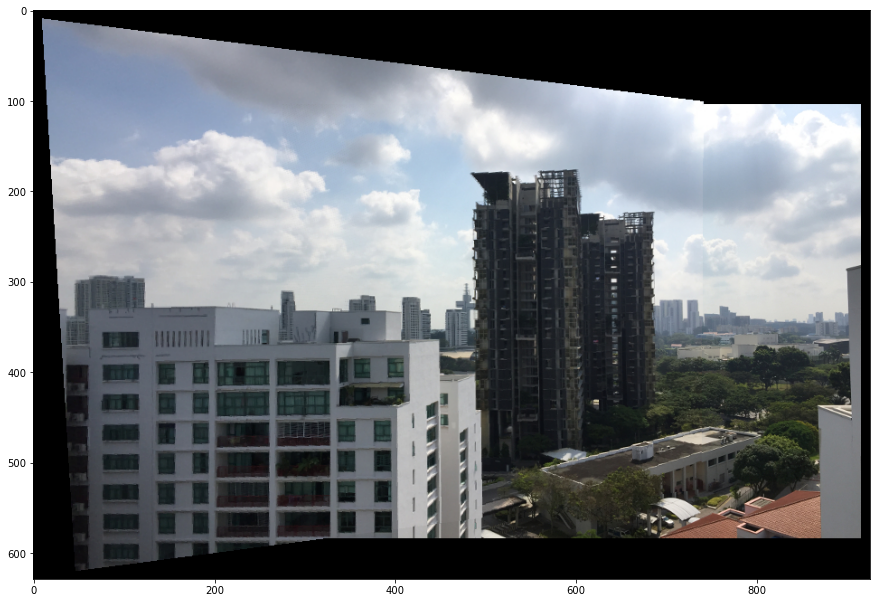

In [26]:
plt.figure( figsize=(15,15) )
plt.imshow(output_img)

In [27]:
# delete matches lines in m_p
m_p = np.delete(m_p,match,axis = 0)
summ = m_p[:,match[0]]+m_p[:,match[1]]
summ = np.matrix(summ).T
m_p = np.delete(m_p,match,axis = 1)
m_p = np.concatenate((summ,m_p),axis = 1)

# delete stitched image
del im[match[0]]
del im[match[1]]
del img[match[0]]
del img[match[1]]

[[ 3.55359552e+00  7.78526444e-01 -9.65100286e+02]
 [ 2.34861493e-01  3.66177726e+00 -2.30862469e+03]
 [ 9.10897329e-04  2.76496276e-03  1.00000000e+00]]
[9.711702573592813, 966.7814667042799, 583.3280104732619, 1278.2822427995109]


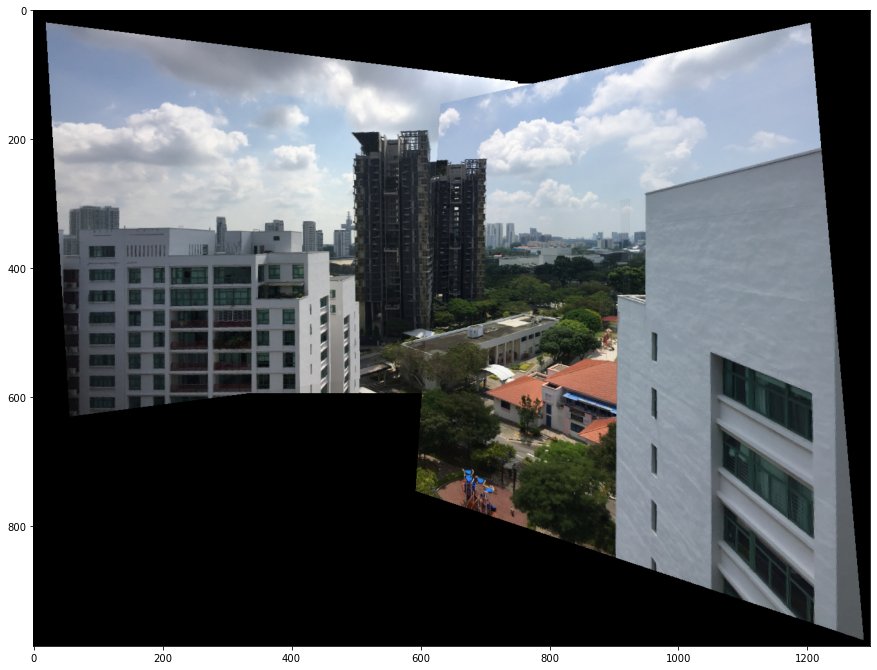

In [28]:
# 2nd stitching
match = num_stitch(m_p,2)
[output_im,output_img] = stitch(output_im,im[match[1]],output_img,img[match[0]])
plt.figure( figsize=(15,15) )
plt.imshow(output_img)